In [113]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.integrate import quad, dblquad
from scipy.interpolate import interp1d

# Norms for the PMNS matrix squared:
u_e = [0, 0.674743, 0.302844, 0.0224125]
u_m = [0, 0.0946105, 0.360415, 0.544974]
u_t = [0, 0.230646, 0.33674,  0.432613]


# Effective distance traveled in 1oeV:
l_eff = 4.4434e23 * 5.06773093741 * 1e6

# Importing hypotheses and bin edges
hypotheses = pd.read_csv('hypotheses.csv')
bin_edges = pd.read_csv('bin_edges.csv')

# concatenating
frames = [bin_edges, hypotheses]
ngc_chart = pd.concat(frames, axis=1)

# Importing effective area data:
eff_a = np.loadtxt('effA_-5to30.dat')

# Limits of energy bins in the effective area data:
e_min = 1e-1
e_max = 7.94328e5

# More parameters:
phi0 = 5e-11 * 275270400 # TeV^-1 cm^-2 over 3168 days
e0 = 1 # TeV
index = 3.2 # Taken from NGC paper
width = 0.3 # In log10 scale, for track-like events

# del_m2
del_m2 = 0

base = 10


         energy      null     alt_1     alt_2
0      0.100000  0.313101  0.161677  0.427268
1      0.112202  0.412408  0.213504  0.562626
2      0.125893  0.513789  0.265627  0.694203
3      0.141254  0.628737  0.324685  0.841257
4      0.158489  0.756485  0.390103  1.001822
..          ...       ...       ...       ...
76   630.957344  0.007889  0.007888  0.005047
77   707.945784  0.006613  0.006613  0.004139
78   794.328235  0.005535  0.005534  0.003389
79   891.250938  0.004624  0.004624  0.002769
80  1000.000000       NaN       NaN       NaN

[81 rows x 4 columns]


In [164]:
def TrueIntegrand(e_true, e_reco, del_m2):

    exp_e_true = 10**(e_true)

    flux = (exp_e_true/e0)**(-index)

    log_gauss = norm.pdf(e_true, e_reco, 0.3)
    
    # Finding the appropriate effective area for the given true energy
    x = eff_a[:,0]
    y = eff_a[:,4]
    f = interp1d(x, y)
    effa = 10000*f(exp_e_true) # cm^2, in data set as m^2

    # Calculating probability that the neutrino will be a muon neutrino (change e_true to eV): 
    osc = (np.cos((del_m2 * l_eff)/(4*exp_e_true*1e12)))**2
    prob_surv = osc * ((u_m[1]*u_m[1]) + (u_m[2]*u_m[2]) + (u_m[3]*u_m[3]))
    prob_emu = osc * ((u_e[1]*u_m[1]) + (u_e[2]*u_m[2]) + (u_e[3]*u_m[3]))
    prob_mu = 0.666666*prob_surv + 0.333333*prob_emu 
   
    # jacobian = exp_e_true*np.log(10)
    log_integrand = log_gauss*flux*effa*prob_mu

    # print(f"flux: {flux}")
    # print(f"gauss: {log_gauss}")
    # print(f"effa: {effa}")
    # print(f"prob_mu: {prob_mu}")
    # print(f"jacobian: {jacobian}")
    # print(f"log_integrand: {log_integrand}")
    
    return log_integrand



def RecoIntegrand(e_reco, del_m2):
    # lower_bound = max(e_min, e_reco-5*np.power(base, 0.3))
    # upper_bound = min(e_max, e_reco+5*np.power(base, 0.3))
    lower_bound = max(np.log10(e_min), e_reco-1.5)
    upper_bound = min(np.log10(e_max), e_reco+1.5)
    # print(lower_bound)
    # print(upper_bound)  
    true_int = quad(TrueIntegrand, lower_bound, upper_bound, args=(e_reco, del_m2), limit=50, epsabs=0.5)
    return 3*phi0*true_int[0]


In [ ]:
def RecoInt(e_start, e_end, del_m2):
    return quad(RecoIntegrand, e_start, e_end, args=(del_m2, ), limit=20, epsabs=0.5)[0]

def Integral(e_start, e_end, del_m2):
    int = dblquad(TrueIntegrand, e_start, e_end, lambda y: y-1.5, lambda y: y+1.5, args=(del_m2, ), epsabs=0.5)
    return int[0]

In [168]:
test = RecoIntegrand(0, 0)*0.05
print(test)

2.2805415414496255


In [126]:
a = np.linspace(-1, 1.5, 10000)
b = []
# for i in range(len(a)):
#     b.append(TrueIntegrand(a[i], 0, 0))
# fig, ax = plt.subplots()
# hyp_178, = ax.plot(a, b)

test = RecoIntegrand(-1, 0)*0.05
print(test)


-1.0
0.5
1.1618585299899158


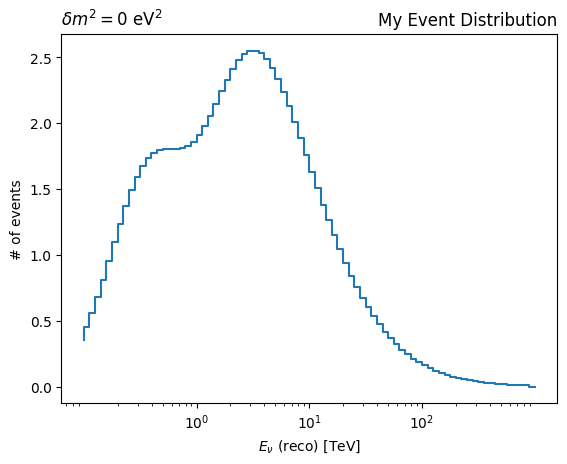

In [172]:
int_approx = []
int_approx1 = []
for i in range(len(ngc_chart['energy']) - 1):
    e_t = np.log10(ngc_chart['energy'][i])
    e_t_next = np.log10(ngc_chart['energy'][i+1])
    int_approx.append(RecoIntegrand(e_t, 0)*(e_t_next-e_t))
    int_approx1.append(RecoIntegrand(e_t_next, 10**(-17.8))*(np.power(10, e_t_next)-np.power(10, e_t)))
    # int_approx.append(Integral(e_t, e_t_next, 0))
int_approx.append(0)
int_approx1.append(0)

fig, ax = plt.subplots()
# null, = ax.step(ngc_chart['energy'], ngc_chart['null'])
# hyp_178, = ax.step(ngc_chart['energy'], int_approx)
hyp_1781, = ax.step(ngc_chart['energy'], int_approx1)
ax.set_xscale('log')
ax.set_xticks([10**0, 10**1, 10**2])
ax.set_xlabel(r"$E_{\nu}$ (reco) [TeV]")
ax.set_ylabel(r"# of events")
ax.set_title(r"$\delta m^2 = 0$ eV$^2$", loc="left")
ax.set_title(r"My Event Distribution", loc="right")
plt.show()

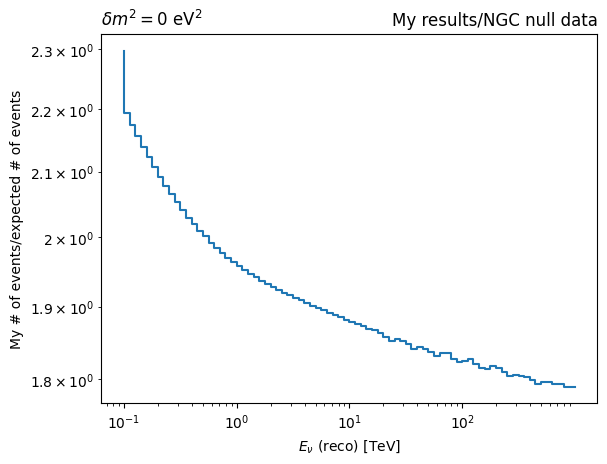

In [171]:
# print(int_approx/ngc_chart['null'])
# print(len(ngc_chart['null']))
ratio = []
for i in range(len(ngc_chart['null'])-1):
    ratio.append(int_approx1[i]/ngc_chart['null'][i])
ratio.append(ratio[len(ngc_chart['null'])-2])
fig, ax = plt.subplots()
hyp_178, = ax.step(ngc_chart['energy'], ratio)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([10**-1, 10**0, 10**1, 10**2])
ax.set_xlabel(r"$E_{\nu}$ (reco) [TeV]")
ax.set_ylabel(r"My # of events/expected # of events")
ax.set_title(r"$\delta m^2 = 0$ eV$^2$", loc="left")
ax.set_title(r"My results/NGC null data", loc="right")
plt.show()

# print(ratio)
# print(len(ratio))
# print(ngc_chart['null'][79])